In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [3]:
import kagglehub

path = kagglehub.dataset_download(
    "sriramr/fruits-fresh-and-rotten-for-classification"
)

print("Dataset path:", path)


Using Colab cache for faster access to the 'fruits-fresh-and-rotten-for-classification' dataset.
Dataset path: /kaggle/input/fruits-fresh-and-rotten-for-classification


In [4]:
os.listdir(path)


['dataset']

In [5]:
DATASET_DIR = os.path.join(path, "dataset")

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test classes:", os.listdir(TEST_DIR))


Train classes: ['rottenbanana', 'freshoranges', 'rottenoranges', 'freshbanana', 'rottenapples', 'freshapples']
Test classes: ['rottenbanana', 'freshoranges', 'rottenoranges', 'freshbanana', 'rottenapples', 'freshapples']


In [6]:
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"   # 🔥 VERY IMPORTANT
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


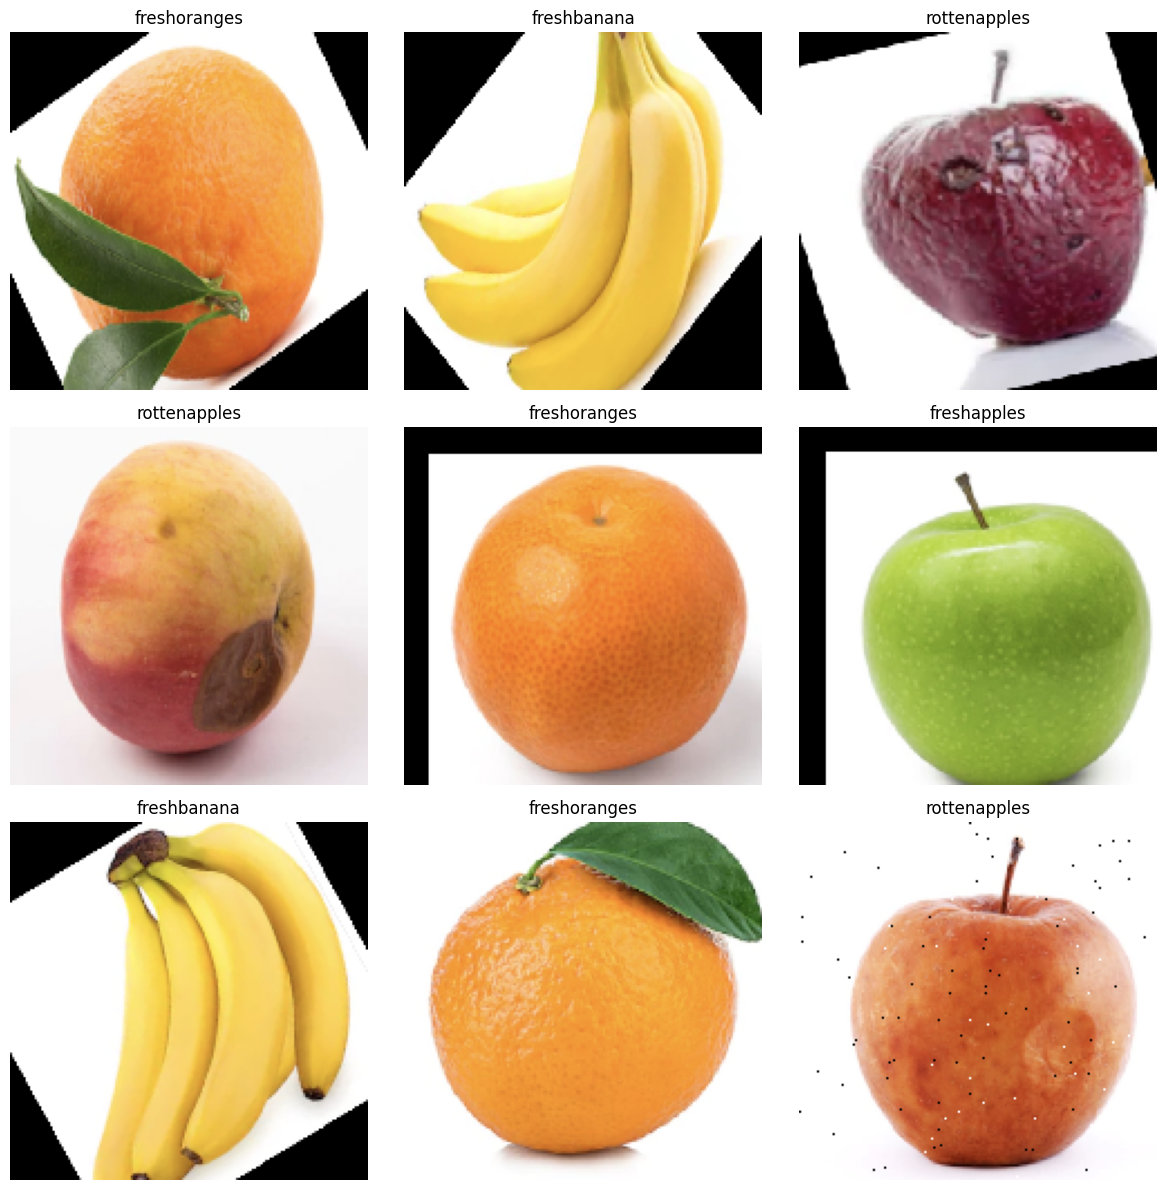

In [17]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(12, 12))

for i in range(9):
    # Select random image from training set
    img_path = random.choice(train_data.filepaths)

    # Load image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)

    # Get label from folder name
    label = img_path.split("/")[-2]

    # Plot image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
print(train_data.class_indices)


{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


In [10]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(160,160,3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
output = Dense(6, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 361,606 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
EPOCHS = 5

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    steps_per_epoch=40,
    validation_steps=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6054 - loss: 1.0699 - val_accuracy: 0.9187 - val_loss: 0.2782
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9300 - loss: 0.2353 - val_accuracy: 0.9125 - val_loss: 0.2365
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9473 - loss: 0.1661 - val_accuracy: 0.9750 - val_loss: 0.0996
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9608 - loss: 0.1337 - val_accuracy: 0.9604 - val_loss: 0.1187
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9670 - loss: 0.1010 - val_accuracy: 0.9729 - val_loss: 0.0829


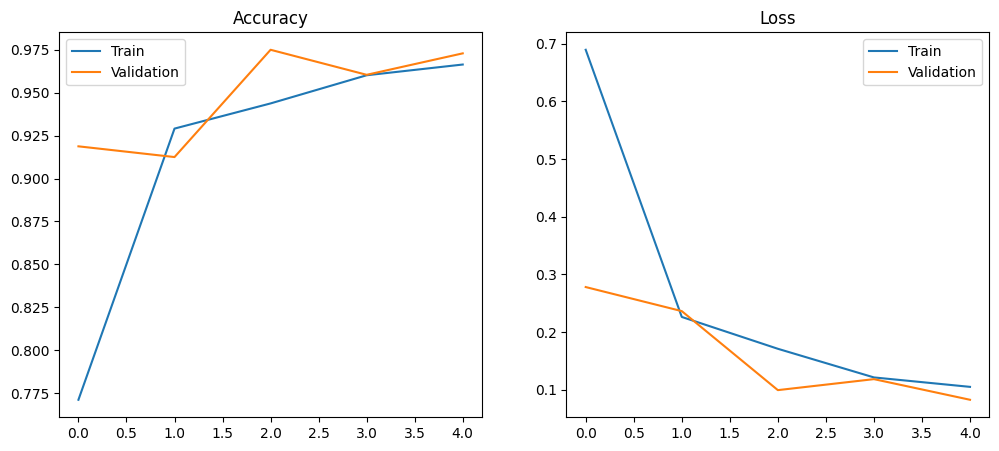

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.title("Loss")

plt.show()


In [13]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_data,
    validation_data=test_data,
    epochs=3,
    steps_per_epoch=40,
    validation_steps=15
)


Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6737 - loss: 0.9549 - val_accuracy: 0.9583 - val_loss: 0.1208
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8915 - loss: 0.3100 - val_accuracy: 0.9563 - val_loss: 0.1085
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9456 - loss: 0.1857 - val_accuracy: 0.9625 - val_loss: 0.1043


85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 778ms/step


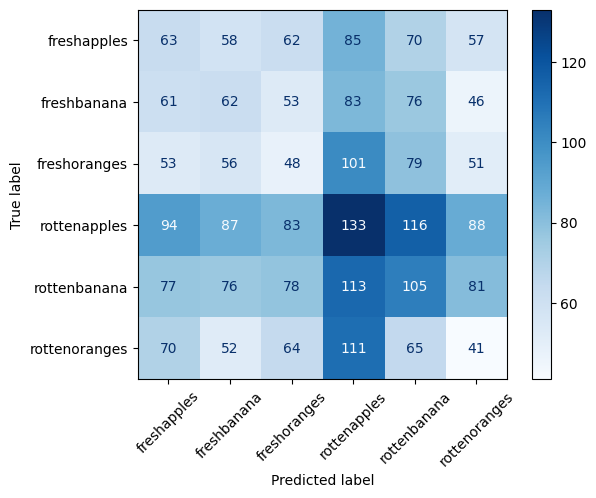

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(train_data.class_indices.keys())
)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


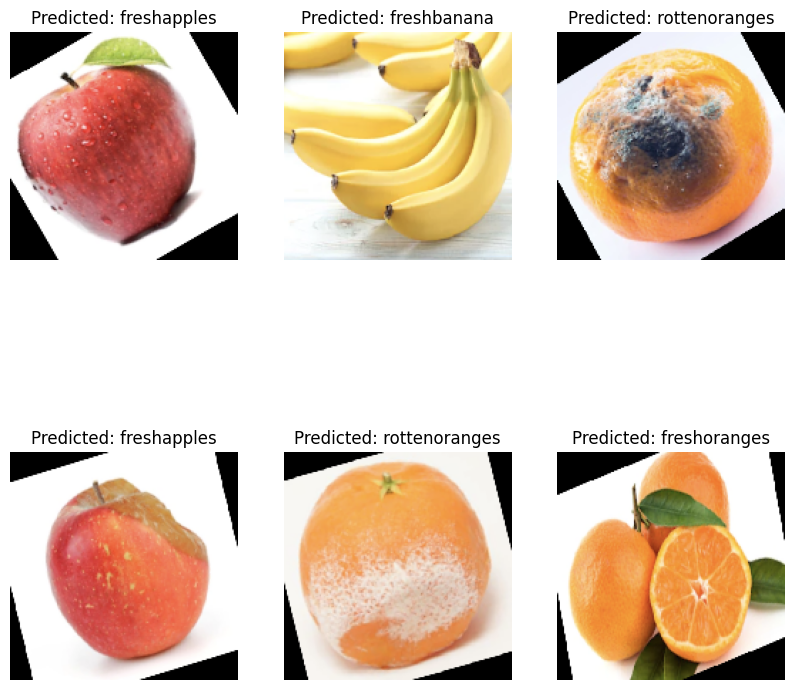

In [15]:
import random
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(10,10))

class_names = list(train_data.class_indices.keys())

for i in range(6):
    img_path = random.choice(test_data.filepaths)

    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction)]

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class}")
    plt.axis("off")

plt.show()


In [16]:
model.save("food_freshness_model.h5")
print("Model saved successfully!")


Model saved successfully!
